In [38]:
import numpy as np
         
from matplotlib import pyplot as plt

import csb
import pandas as pd 
from Bio import SeqIO
import pandas as pd
from colour import Color
import pickle



In [39]:
    #Read Newick file (A Newick file is a standard file format for storing phylogenetic trees)

    
dataset = './'
    
import dendropy
tree = dendropy.Tree.get(
    path='./UKdata/cog_global_2020-05-08_tree.newick',
    schema='newick')
print(dir(tree))




['B1', 'N_bar', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_as_newick_string', '_assign_node_labels_from_taxon', '_bipartition_edge_map', '_clone_from', '_compile_immutable_bipartition_for_edge', '_compile_mutable_bipartition_for_edge', '_debug_check_tree', '_debug_tree_is_valid', '_del_taxon_namespace', '_del_taxon_set', '_format_and_write_to_stream', '_get_annotations', '_get_bipartition_edge_map', '_get_from', '_get_indented_form', '_get_is_rooted', '_get_is_rootedness_undefined', '_get_is_unrooted', '_get_label', '_get_seed_node', '_get_split_bitmask_edge_map', '_get_split_edges', '_get_taxon_namespace', '_get_taxon_set', '_has_annotations', '_is

In [40]:
for l in tree.leaf_nodes()[0:10]:
    print(str(l.taxon).replace("'" , '' ))
    
for i,n in enumerate(tree.nodes()):
    n.matrow = i

for l in tree.leaf_nodes()[0:10]:
    print(l.matrow)


USA/WA-S89/2020
USA/WA-S90/2020
USA/OR-UW-1849/2020
USA/AZ-TG268903/2020
USA/CT-Yale-041/2020
USA/WA-S87/2020
USA/WA7-UW4/2020
USA/WA-S96/2020
USA/WA-S95/2020
USA/WA-S97/2020
7
8
9
10
11
13
14
16
17
18


In [50]:
from Bio import AlignIO , SeqIO
#msa = AlignIO.read('./UKdata/cog_2020-05-08_alignment.fasta' , format = 'fasta')

sequences = SeqIO.parse('./gisaid/msa_0611.fasta' , format = 'fasta')

with open('./gisaid/msa_0611.lenfilter.fasta'  , 'w'):
    for i,s in enumerate(sequences):
        print(len(s))
        if i > 10:
            break



print(msa)
align_array = np.array([list(rec) for rec in msa], np.character)
print(align_array)

46628
46628
46628
46628
46628
46628
46628
46628
46628
46628
46628
46628
SingleLetterAlphabet() alignment with 14277 rows and 29903 columns
--------------------------------------------...--- England/BIRM-5E2A3/2020
--------------------------------------------...--- England/BIRM-5E2B2/2020
--------------------------------------------...--- England/BIRM-5E2C1/2020
--------------------------------------------...--- England/BIRM-5E2D0/2020
--------------------------------------------...--- England/BIRM-5E2EF/2020
--------------------------------------------...--- England/BIRM-5E2FE/2020
--------------------------------------------...--- England/BIRM-5E30A/2020
--------------------------------------------...--- England/BIRM-5E319/2020
--------------------------------------------...--- England/BIRM-5E328/2020
--------------------------------------------...--- England/BIRM-5E346/2020
--------------------------------------------...--- England/BIRM-5E364/2020
------------------------------------

KeyboardInterrupt: 

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
29903
8775


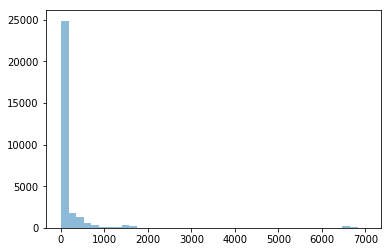

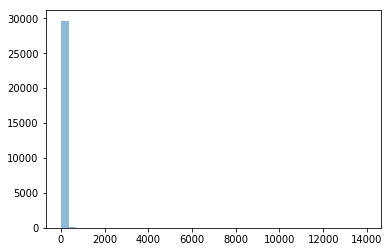

A
C
T
G
N
-


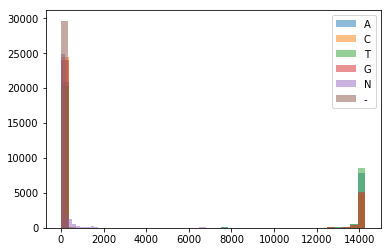

In [42]:
IDs = {i:rec.id for i,rec in enumerate(msa)}
IDindex = dict(zip( IDs.values() , IDs.keys() ) )

from collections import Counter
#sites = { col: Counter( msa[:,col] ) for col in range(len(msa[1,:])) }
sites = {}
for col in range(len(msa[1,:])):
    sites.update({col:Counter(msa[:,col])})
    if col% 1000  == 0:
        print(col)


#remove uniformative sites from counter
#send the informative ones to MI analysis
informativesites = [ s for s in sites if len(set( sites[s].keys()) -set(['-','N']) ) > 1  ]

print(len(sites))

print(len(informativesites))

nvec = [ sites[s]['N'] for s in sites ]
plt.hist(nvec , alpha = .5 , bins = 40)
plt.show()

gapvec = [ sites[s]['-'] for s in sites ]
plt.hist(gapvec , alpha = .5  , bins = 40)
plt.show()

for letter in [ 'A' , 'C' ,'T' ,'G' , 'N' ,'-']:
    print(letter)
    lettervec = [ sites[ID][letter] if letter in sites[ID] else 0  for ID in sites  ]
    plt.hist(lettervec , alpha = .5 , label = letter , bins = 40)
plt.legend()
#filter further for artifacts using boruta here

In [43]:
print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )

print( IDindex['USA/WA-S89/2020'] )



[('England/BIRM-5E2A3/2020', 0), ('England/BIRM-5E2B2/2020', 1), ('England/BIRM-5E2C1/2020', 2), ('England/BIRM-5E2D0/2020', 3), ('England/BIRM-5E2EF/2020', 4), ('England/BIRM-5E2FE/2020', 5), ('England/BIRM-5E30A/2020', 6), ('England/BIRM-5E319/2020', 7), ('England/BIRM-5E328/2020', 8), ('England/BIRM-5E346/2020', 9)]


KeyError: 'USA/WA-S89/2020'

In [45]:

#place an event on a column with multiple symbols
allowed_symbols = ['A','C', 'G' , 'T ']
from time import sleep

def process_node_smallpars_1(node):
    #go from leaves up and generate character sets
    if node.symbols is None:
        for child in node.child_nodes():
            if child.symbols is None:
                process_node_smallpars_1(child)
        node.symbols = set.intersection( [ child.symbols for child in node.child_nodes( ) ] )
        if len(symbols) == 0:
            node.symbols = set.union( [ child.symbols for child in node.child_nodes( ) ] )
        node.scores = { }
        for c in allowed_symbols:
            if c not in node.symbols:
                #add trnasition mat here
                score = min( [ child.scores[c] for child in node.child_nodes()])+1
            else:
                score = min(  [ child.scores[c] for child in node.child_nodes() ] )
            node.scores[c] = score
            
def process_node_smallpars_2(node):
    #assign the most parsimonious char from children or keep a set
    if node.char is None:
        node.char = min(node.score, key=node.scores.get)
        
        
        
        if node.parent_node.char == node.char:
            node.event = 0
        else:
            node.event = 1
        for child in node.child_nodes():
            if child.char is None:
                process_node_smallpars_2(child)

def calculate_small_parsimony( t, aln_column , row_index  ):           
    
    #assign leaf values
    for l in t.leaf_nodes():
        l.event = 0
        try:
            char = aln_column[row_index[str(l.taxon).replace("'" , '' )]]
        except KeyError:
            print(l.taxon)
            char = None
        if char in allowed_symbols:
            l.symbols = { char }
        else:
            #ambiguous leaf
            l.symbols = set( allowed_symbols )
        l.scores = { c:0 if c in l.symbols else 10**10 for c in allowed_symbols }
        l.char = l.symbols
    
    #up
    process_node_smallpars_1(t.root)                                 
    #down
    process_node_smallpars_2(t.root)
    eventindex = [ n.matrow for n in t.nodes()   if n.event > 0 ]
    events = np.zeros( (len(t.nodes(),1) ) )                            
    events[eventindex] = 1
    return events

                      
aln_column = align_array[:, informativesites[100] ]

print(calculate_small_parsimony( tree, aln_column ,  IDindex  ) )
                      

'USA/WA-S89/2020'
'USA/WA-S90/2020'
'USA/OR-UW-1849/2020'
'USA/AZ-TG268903/2020'
'USA/CT-Yale-041/2020'
'USA/WA-S87/2020'
'USA/WA7-UW4/2020'
'USA/WA-S96/2020'
'USA/WA-S95/2020'
'USA/WA-S97/2020'
'USA/WA-S94/2020'
'USA/WA-S77/2020'
'USA/WA-S78/2020'
'USA/WA-S81/2020'
'USA/WA-S272/2020'
'USA/WA-S80/2020'
'USA/WA-S86/2020'
'USA/WA-S20/2020'
'USA/WA15-UW11/2020'
'USA/WA16-UW12/2020'
'USA/WA-S139/2020'
'USA/WA-UW68/2020'
'USA/WA-UW-1587/2020'
'USA/WA-S19/2020'
'USA/WA-UW244/2020'
'USA/WA-S140/2020'
'USA/WA-S107/2020'
'USA/WA-S106/2020'
'USA/WA-S58/2020'
'USA/WA-UW-1835/2020'
'USA/WA-S161/2020'
'USA/WA-S160/2020'
'USA/WA17-UW13/2020'
'USA/WA-UW31/2020'
'USA/WA-S22/2020'
'USA/WA-S23/2020'
'USA/WA-UW323/2020'
'USA/WA-UW332/2020'
'USA/WA-UW338/2020'
'USA/UN-UW-1403/2020'
'USA/WA-UW286/2020'
'USA/WA-UW40/2020'
'USA/WA-S529/2020'
'USA/WA-S83/2020'
'USA/WA-UW47/2020'
'USA/WA-S273/2020'
'USA/WA-S110/2020'
'USA/WA-S270/2020'
'USA/WA-UW-1946/2020'
'USA/WA-UW363/2020'
'USA/WA-UW129/2020'
'USA/WA-UW-16

AttributeError: 'Tree' object has no attribute 'root'

In [1]:
def process(q,retq, iolock ,t , row_index , node_index  ):
    #calculate compression distances
    with iolock:
        print('init worker')
    while True:
        index,aln_column = q.get()
        if stuff is None:
            break
        retq.put((index,calculate_small_parsimony( t, aln_column , row_index , node_index  ) ) ) 
    print('done')
                      
def mat_creator(retq,matsize,iolock):
    with iolock:
        print('init matcreator')
    #collect distances and create final mat
    calculations = (matsize**2 - matsize) / 2
    
    distmat = np.zeros((matsize,matsize))
    count = 0
    
    with h5py.File('./UKdata/alnMI2.h5', 'a') as hf:
        try:
            hf.create_dataset("alnEvents",  data=distmat)
        except:
            pass
        while True:
            r = retq.get()
            count+=1
            if r is None:
                break
            row,events = r
            hf['alnEvents'][row,col] = cdist
            if count% 100000 == 0 :
                with iolock:
                    print(count/calculations)
                    print((row,col))
                    hf.flush()
    print('done saver')

startk = 0 
startl = 0

if __name__ == '__main__':
    NCORE = 64
    q = mp.Queue(maxsize=NCORE*5000)
    retq = mp.Queue(maxsize=NCORE*5000)
    iolock = mp.Lock()
    pool = mp.Pool(NCORE, initializer=process, initargs=(q,retq, iolock))
    p = mp.Process(target=mat_creator, args=(retq,len(msa[1,:]), iolock))
    p.start()
    for k,i in enumerate(informativesites):
        for l,j in enumerate(informativesites):
            if k < l and k> startk and l > startl :
                s1 = align_array[:,i].ravel()
                s2 = align_array[:,j].ravel()
                q.put( (i,j,s1,s2) )         
                if k % 100 == 0 and l %100 == 0:
                    print((k,l))
                    print((i,j))
    
    for _ in range(NCORE):  # tell workers we're done
        q.put(None)
    retq.put(None)
    pool.close()
    pool.join()
    p.join()
                                     

In [6]:
meta_data = pd.read_csv('UKdata/cog_2020-05-08_metadata.csv')
print(meta_data)


                           sequence_name country    adm1 sample_date  \
0      Northern_Ireland/NIRE-1022DA/2020      UK  UK-NIR  2020-03-23   
1      Northern_Ireland/NIRE-1023C8/2020      UK  UK-NIR  2020-03-18   
2      Northern_Ireland/NIRE-102137/2020      UK  UK-NIR  2020-03-19   
3      Northern_Ireland/NIRE-1023AA/2020      UK  UK-NIR  2020-03-21   
4      Northern_Ireland/NIRE-1022E9/2020      UK  UK-NIR  2020-03-24   
...                                  ...     ...     ...         ...   
16375                Scotland/CVR04/2020      UK  UK-SCT  2020-03-04   
16376                Scotland/CVR05/2020      UK  UK-SCT  2020-03-04   
16377                Scotland/CVR03/2020      UK  UK-SCT  2020-03-01   
16378                Scotland/CVR02/2020      UK  UK-SCT  2020-03-02   
16379                Scotland/CVR01/2020      UK  UK-SCT  2020-02-28   

       epi_week lineage  lineage_support  
0            13     B.1             99.0  
1            12   B.2.2            100.0  
2     

In [ ]:
#sequences = { ID:Counter( msa[i,:]) for i,ID in enumerate(IDs) }
sequences = {}
for i in range(len(msa)):
    sequences.update({i:Counter(msa[i,:])})
    if i% 1000  == 0:
        print(i)

In [ ]:
with open('./UKdata/site_seq_stats.pkl' , 'wb') as pickleout:
    pickleout.write(pickle.dumps([sites,informativesites, IDs , sequences]) )
    

In [8]:
with open('./UKdata/site_seq_stats.pkl' , 'rb') as pickleout:
    sites,informativesites, IDs , sequences = pickle.loads(pickleout.read())


In [8]:
#find colum mutual info using compression distance
#find interprot and intraprot interactions

import itertools
import gzip
import multiprocessing as mp
import lzma

import time

lzma_filters = my_filters = [
    {
      "id": lzma.FILTER_LZMA2, 
      "preset": 9 | lzma.PRESET_EXTREME, 
      "dict_size":len(msa[:,0]) * 40, # a big enough dictionary, but not more than needed, saves memory
      "lc": 3,
      "lp": 0,
      "pb": 0, # assume ascii
      "mode": lzma.MODE_NORMAL,
      "nice_len": 273,
      "mf": lzma.MF_BT4
    }
]

def clen(s):
    return len( lzma.compress(s, format=lzma.FORMAT_RAW, filters= lzma_filters) )
    #return len(gzip.compress(s))

def compress_dist(pargs):
    i,j,s1,s2 = pargs
    strings = [s1.ravel() , s2.ravel() , np.stack([s1,s2]).ravel() ]
    ls1 , ls2 , ls1_2 = map(clen, strings)
    
    return  (i,j,(ls1_2 - min(ls1,ls2) )/ max( ls1,ls2 ) )


def str2binary(s,char):
    return np.array([ 1 if c == char else 0 for c in s ])

def byteStr2str(s):
    return b"".join(list(s)).decode()

def binaryH(s):
    H = 0 
    for c in set(s):
        p = np.sum(str2binary(s,c))/len(s)
        H+= p*np.log(p)
    return H
    
def binaryJointH(s1,s2):
    
    H = 0
    for c1 in set(s1+s2):
        for c2 in set(s1+s2):
            v1 = str2binary(s1,c1)
            v2 = str2binary(s2,c2)
            
            sumvec = np.sum(np.vstack([v1,v2]) , axis = 0)
            pvec = np.zeros()
            pvec[np.where( sumvec == 2)] =1
            p = np.sum(pvec)
            H+= p*np.log(p)
    return H

        

def MI_dist(pargs):
    #calculate explicit MI
    
    #Hx + Hy - HXY
    
    
    i,j,s1,s2 = pargs
    binaryH(s1) + binaryH(s2) - binaryJointH(s1,s2)
    strings = [s1.ravel() , s2.ravel() , np.stack([s1,s2]).ravel() ]
    
    ls1 , ls2 , ls1_2 = map(clen, strings)
    return  (i,j,(ls1_2 - min(ls1,ls2) )/ max( ls1,ls2 ) )

In [8]:
print(len(informativesites))

print(clen(align_array[:,100].ravel()))
print(clen(align_array[:,1000].ravel()) )

print(( 308 - 163) / 183 )
both = np.stack( [align_array[:,100].ravel(), align_array[:,1000].ravel()])
print(clen(both) )
print(compress_dist((100,1000, align_array[:,100],  align_array[:,1000]) ))

complement = { 'A':'T' , 'T':'A' , 'C':'G' , 'G':'C' }
newstr =  ''.join([complement[c]  if c in complement else c  for c in msa[:,informativesites[3]] ])

t0 = time.time()
print( compress_dist(   ( 100, 100 , align_array[:,informativesites[3]], align_array[:,informativesites[3]] ) ) )
print( time.time() -t0)
#select 100 random pairs

#select 100 sites and take complement


#double hist

print( len(informativesites) ** 2)

print( len(informativesites) ** 2 /  2* 100000)

NameError: name 'informativesites' is not defined

In [ ]:
import h5py
def process(q,retq, iolock):
    #calculate compression distances
    with iolock:
        print('init worker')
    from time import sleep
    while True:
        stuff = q.get()
        if stuff is None:
            break
        retq.put(compress_dist(stuff))
    print('done')
def mat_creator(retq,matsize,iolock):
    with iolock:
        print('init matcreator')
    #collect distances and create final mat
    calculations = (matsize**2 - matsize) / 2
    distmat = np.zeros((matsize,matsize))
    count = 0
    
    with h5py.File('./UKdata/alnMI2.h5', 'a') as hf:
        try:
            hf.create_dataset("alnMI",  data=distmat)
        except:
            pass
        while True:
            r = retq.get()
            count+=1
            if r is None:
                break
            row,col,cdist = r
            hf['alnMI'][row,col] = cdist
            if count% 100000 == 0 :
                with iolock:
                    print(count/calculations)
                    print((row,col))
                    hf.flush()
    print('done saver')

startk = 0 
startl = 0

if __name__ == '__main__':
    NCORE = 64
    q = mp.Queue(maxsize=NCORE*5000)
    retq = mp.Queue(maxsize=NCORE*5000)
    iolock = mp.Lock()
    pool = mp.Pool(NCORE, initializer=process, initargs=(q,retq, iolock))
    p = mp.Process(target=mat_creator, args=(retq,len(msa[1,:]), iolock))
    p.start()
    for k,i in enumerate(informativesites):
        for l,j in enumerate(informativesites):
            if k < l and k> startk and l > startl :
                s1 = align_array[:,i].ravel()
                s2 = align_array[:,j].ravel()
                q.put( (i,j,s1,s2) )         
                if k % 100 == 0 and l %100 == 0:
                    print((k,l))
                    print((i,j))
    
    for _ in range(NCORE):  # tell workers we're done
        q.put(None)
    retq.put(None)
    pool.close()
    pool.join()
    p.join()

In [9]:
#Initialise a vector of zeros with length equal to the number of sites in the alignment to record the tree length for each site
import numpy as np
import h5py
from scipy.sparse import coo_matrix
with h5py.File('./UKdata/alnMI2.h5', 'r') as hf:
    print( hf['alnMI'] )
    MImat = np.array(hf['alnMI'])
print(MImat)

<HDF5 dataset "alnMI": shape (29903, 29903), type "<f8">
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


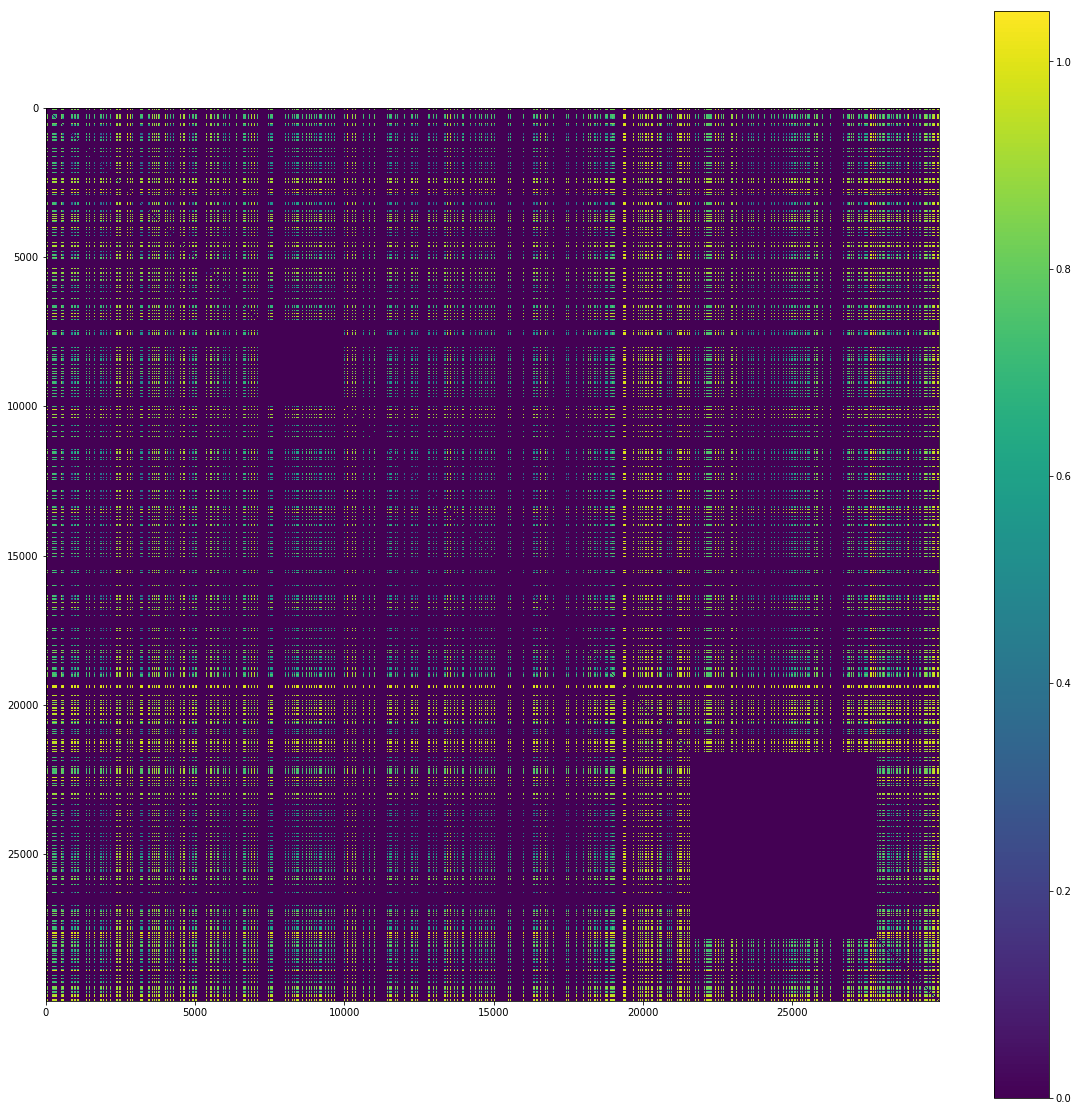

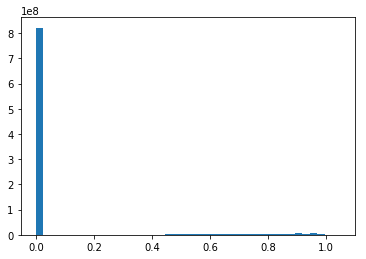

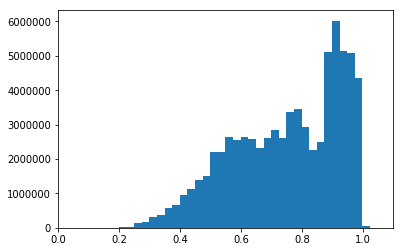

In [10]:
MImat += MImat.T
#MImat = 1-MImat
#sparseMI = coo_matrix(MImat)
plt.figure(figsize = (20,20))
plt.imshow(MImat)
plt.colorbar()
plt.show()


plt.hist(MImat.ravel(), bins= 40)
plt.show()
posi = MImat[ np.where( MImat >0 ) ].ravel() 
plt.hist(posi, bins= 40)
plt.show()



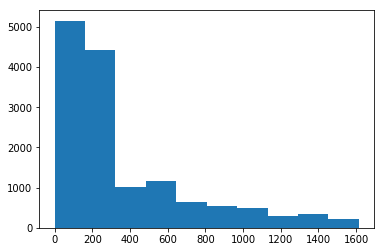

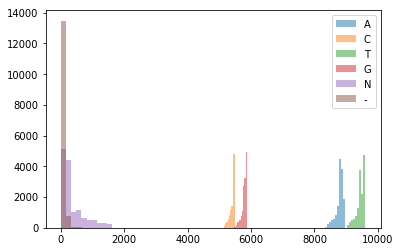

In [8]:
#filter sequences
#sequences with over k undefined characters can be discarded 
nvec = [ sequences[ID]['N'] if 'N' in sequences[ID] else 0  for ID in sequences  ]
plt.hist(nvec)

plt.show()
#make a hist of normalized sequence composition percentages

for letter in [ 'A' , 'C' ,'T' ,'G' , 'N' ,'-']:
    lettervec = [ sequences[ID][letter] if letter in sequences[ID] else 0  for ID in sequences  ]
    plt.hist(lettervec , alpha = .5 , label = letter)
plt.legend()
plt.show()

In [23]:
print(len(sequences))

legit_IDs = [ ID for ID in sequences if sequences[ID]['N'] < 5 ]

print( len(legit_IDs))
print( legit_IDs[0:10])
#matrows = [ IDs[s] for s in legit_IDs ]


14277
3363
[0, 1, 2, 4, 6, 12, 13, 14, 19, 120]


In [24]:
#pick a sequence
sele = 10

print(legit_IDs[sele])
seq = b"".join(list(align_array[sele,:])).decode()

print(seq[0:100])

cleanseq = seq.replace('-','')

print(len(seq))
print(len(cleanseq))
#select all nongap positions
nongap_cols = [ i for i,s in enumerate(seq) if s is not '-']
#map each nucleotide to an aln col
nongap_cols = { i:col for i,col in enumerate(nongap_cols) }

print(len(nongap_cols))

print(cleanseq[0:100]+'...')
#fasta = '>'+legit_IDs[sele]+'\n'+seq
#with open( 'testgeno.fasta' ,'w')as geno_out:
#    geno_out.write(fasta)co
print( len(seq) )

151
------------------------------------------------------AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC
29903
29782
29782
AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTT...
29903


In [ ]:
import subprocess
import shlex
#####run glimmer and build icm 
#####predict orfs in a viral genome

def runblastx( aln , name, path , outdir, db , iterations , ncores , runName='' , SS= False  , ohhm = False , verbose = True , Z = 2000 , B = 2000 , xargs = ' -cons '):
    
    #blastx -query testgeno.fasta -db covid_prots -outfmt 10
    
    
    if verbose == True:
        print( [aln , name, path , outdir, db , iterations , ncores , runName] )
    
    outhhr= outdir+name+runName+".hhr"
    args = path + ' -cpu '+ str(ncores) +' -d ' + db + ' -i ' + aln  +' -o '+ outhhr + ' -n ' + str(iterations) + ' -B '+ str(B) + ' -Z ' + str(Z) +' '+ xargs 
    if SS == True:
         args += ' -ssm 2 -ssw .5 '
    
    if ohhm == True:
        outa3m = outdir+name+runName+'.a3m'
        args += ' -Oa3m ' + outa3m
    else: 
        outa3m = None
    if verbose == True:
        print(args)
    
    args = shlex.split( args)
    p = subprocess.run( args )
    return p , [outhhr,outa3m]


def runGlimmer( aln , name, path , outdir, db , iterations , ncores , runName='' , SS= False  , ohhm = False , verbose = True , Z = 2000 , B = 2000 , xargs = ' -cons '):
    # glimmer3.02/bin/glimmer3 --linear -g 20 -o 50 testgeno.fasta testgeno.fasta.icm test

    if verbose == True:
        print( [aln , name, path , outdir, db , iterations , ncores , runName] )
    
    outhhr= outdir+name+runName+".hhr"
    args = path + ' -cpu '+ str(ncores) +' -d ' + db + ' -i ' + aln  +' -o '+ outhhr + ' -n ' + str(iterations) + ' -B '+ str(B) + ' -Z ' + str(Z) +' '+ xargs 
    if SS == True:
         args += ' -ssm 2 -ssw .5 '
    
    if ohhm == True:
        outa3m = outdir+name+runName+'.a3m'
        args += ' -Oa3m ' + outa3m
    else: 
        outa3m = None
    if verbose == True:
        print(args)
    
    args = shlex.split( args)
    p = subprocess.run( args )
    return p , [outhhr,outa3m]

In [25]:
#read orf file
from Bio import Seq
genes = {}
with open('./test.predict' , 'r') as predictions:
    for l in predictions:
        print(l)
        if '>' in l:
            genome = l.strip()
        else:
            words = l.split()
            start = int(words[1])
            stop = int(words[2])
            if stop-start>100:
                genes.update({ genome + '_' + words[0] : { 'genome': genome , 'start':start , 'stop':stop , 'RF':words[3] , 'len':stop-start ,  'score':float(words[4]) , 'seq':seq[start-1:stop-1] } } )
genomesDF = pd.DataFrame.from_dict(genes, orient = 'index')
#translate
genomesDF['prot'] = genomesDF.seq.map( lambda x:str(Seq.Seq(x).translate( ) )  )
print(genomesDF)


>England/BRIS-121F74/2020

orf00075      266    13483  +2     3.00

orf00077    13696    13673  -2     1.82

orf00109    13768    21555  +1     2.99

orf00130    21563    25384  +2     2.99

orf00141    25393    26220  +1     2.94

orf00143    26523    27191  +3     2.92

orf00144    27192    27218  +3     1.78

orf00146    27922    27884  -2     1.69

orf00147    27965    27994  +2     1.27

orf00150    28255    28226  -2     4.36

orf00157    28274    29533  +2     2.96

                                                       genome  start   stop  \
>England/BRIS-121F74/2020_orf00075  >England/BRIS-121F74/2020    266  13483   
>England/BRIS-121F74/2020_orf00109  >England/BRIS-121F74/2020  13768  21555   
>England/BRIS-121F74/2020_orf00130  >England/BRIS-121F74/2020  21563  25384   
>England/BRIS-121F74/2020_orf00141  >England/BRIS-121F74/2020  25393  26220   
>England/BRIS-121F74/2020_orf00143  >England/BRIS-121F74/2020  26523  27191   
>England/BRIS-121F74/2020_orf00157  >England/BRI

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [20]:

#select genomes
#model translated prots
print(genomesDF.prot)
#write out the proteomes

def write_fasta( genos , genodf , path='COVIDpoteomes.fasta'  ):
    with open( path + geno , 'w' ) as fastout:
        for geno in genos:
            sub = genodf[ genodf.genome.is_in( geno ) ]
            for i,r in sub.itterrows():
                fastout.write( '>'+ i + '\n'+ r.prot + '\n' )

def write_split_fasta( geno , genodf , path= None  ):
    #make a folder and split up the fasta for use with hhblits
    
    if path is None:
        
        path = './' + geno+'/'
    sub = genodf[ genodf.genome ==  geno ]

    print(sub)
    
    for i,r in sub.iterrows():
        name = i.replace('>','').replace('/','_')
        print(r)
        with open( path + name + 'singleseq.fasta', 'w' ) as fastout:
            fastout.write( '>'+ i + '\n'+ r.prot + '\n' )

write_split_fasta(    '>England/BRIS-121F74/2020' , genomesDF , path = './UKdata/proteome_' )

>England/BRIS-121F74/2020_orf00075    MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...
>England/BRIS-121F74/2020_orf00109    MVPHISRQRLTKYTMADLVYALRHFDEGNCDTLKEILVTYNCCDDD...
>England/BRIS-121F74/2020_orf00130    MFVFLVLLPLVSSQCVNFTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
>England/BRIS-121F74/2020_orf00141    MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...
>England/BRIS-121F74/2020_orf00143    MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...
>England/BRIS-121F74/2020_orf00157    MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...
Name: prot, dtype: object
                                                       genome  start   stop  \
>England/BRIS-121F74/2020_orf00075  >England/BRIS-121F74/2020    266  13483   
>England/BRIS-121F74/2020_orf00109  >England/BRIS-121F74/2020  13768  21555   
>England/BRIS-121F74/2020_orf00130  >England/BRIS-121F74/2020  21563  25384   
>England/BRIS-121F74/2020_orf00141  >England/BRIS-121F74/2020  25393  26220   
>England/BRIS-121F74/2020_orf00143  >England/BRIS-1

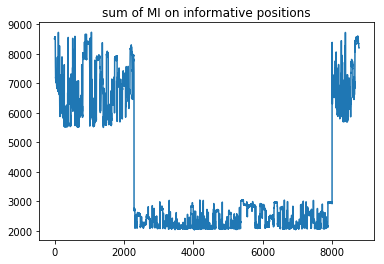

In [118]:
#show residues that contain information: sum of that matrow in the MImat
#these are interaction hubs? 

#!possible masking signal, RNA interactions from geno packing
MIsum = np.sum(MImat , axis =0 ).ravel()

filtered = MIsum[MIsum>0]
plt.plot(filtered)
plt.title('sum of MI on informative positions')
plt.show()

In [89]:
#normalize MIsum
#generate colors in weird pymol format for a specific sequence. this is used with the coloring script written to load this csv

red = Color("red")
blue = Color("blue")
colorscale = list(red.range_to(blue, 100))
MIsum = np.sum(MImat , axis =0 ).ravel()
#add up positions on AA sequences, 3 to 1 codon
MIsumSeq = MIsum[list(nongap_cols.values())]

print(MIsumSeq.shape)
for i,r in genomesDF.itterrows():
    print(i)
    rawvec = list(MIsumseq[r.start:r.stop])
    codonvec = [ sum(codon)/3 for codon in rawvec[::3]]
    plt.plot(codonvec)
    plt.show()

plt.plot(MIsumSeq)
plt.title('sum of MI on sequence')

plt.show()

NameError: name 'MImat' is not defined

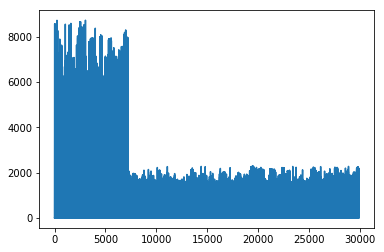

NameError: name 'sub_evoldf' is not defined

In [71]:
sub_evoldf['colorscale'] = sub_evoldf.val.map( lambda x : colorscale[int( x *100 )].rgb)
sub_evoldf['rgb'] = sub_evoldf.colorscale.map( lambda x : '0x'+''.join([ '{:2.2f}'.format(round(min(val ,.99), 2 ) ).replace('.','')[1:]  for val in x ]) ) 

sub_evoldf = sub_evoldf.drop( 'colorscale', axis = 1)
print(sub_evoldf.head())
sub_evoldf.to_csv('MIcolors.csv')

In [39]:
import networkx as nx
import forceatlas2
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import sys
import math

# Load the graph edges and compute the node positions using ForceAtlas2
nprots = len(genomesDF)
r0 = 1000
r_delta = .1
theta_delta = 2*math.pi / nprots
rad_counter = { i:0 for i in range(nprots) }
#node sizes proportional to the MIsum
#ranges = { i }
positions={}
backbone = []

for i, prot in enumerate(genomesDF.index):
    print(prot)
    print(genomesDF.loc[prot])
    count = 0
    for j,col in enumerate(range( genomesDF.loc[prot]['start'] ,  genomesDF.loc[prot]['stop'] )):
        count+=1
        theta = i *theta_delta
        r = r0 + j*r_delta
        positions[col] = np.array([ math.sin(theta)*r , math.cos(theta)*r ])

# read in the distmat
thresh = MImat

thresh[thresh >= .3 ] = 0



#print(indices[0:10])
#thresh = thresh[indices,:]
#thresh = thresh[:,indices]
print(thresh.shape)
G = nx.from_numpy_matrix(thresh)
print('done making graph')
print(len(G.edges()))
print(len(positions))


>England/BRIS-121F74/2020_orf00075
genome                            >England/BRIS-121F74/2020
start                                                   266
stop                                                  13483
RF                                                       +2
len                                                   13217
score                                                     3
seq       ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...
prot      MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...
Name: >England/BRIS-121F74/2020_orf00075, dtype: object
>England/BRIS-121F74/2020_orf00109
genome                            >England/BRIS-121F74/2020
start                                                 13768
stop                                                  21555
RF                                                       +1
len                                                    7787
score                                                  2.99
seq       ATGGTACCACATATATCACGTCAA

In [40]:
print('done graph creation')

nodelist = list(G.nodes())

for node in nodelist:
    if node not in positions:
        G.remove_node(node)

print(len(G.nodes()))
print(len(positions))


done graph creation
27579
27579


In [41]:
for i,e in enumerate(G.edges(data=True)):
    if i < 10:
        print(e)
    else:
        break

(268, 270, {'weight': 0.29577464788732394})
(281, 288, {'weight': 0.26666666666666666})
(291, 299, {'weight': 0.2923076923076923})
(291, 301, {'weight': 0.27692307692307694})
(291, 307, {'weight': 0.29850746268656714})
(299, 301, {'weight': 0.2846153846153846})
(301, 307, {'weight': 0.291044776119403})
(301, 310, {'weight': 0.2937062937062937})
(307, 310, {'weight': 0.2867132867132867})
(351, 355, {'weight': 0.28888888888888886})


In [42]:

print('done nodes')
#add the backbone and MI connection with straight and curved
postuples = [ [ positions[e[0]] , positions[e[1]] ] for e in G.edges(data= True)   if e[0] in positions and e[1] in positions ]
print(len(postuples))

print('done tuples')

done nodes
170085
done tuples


plotting


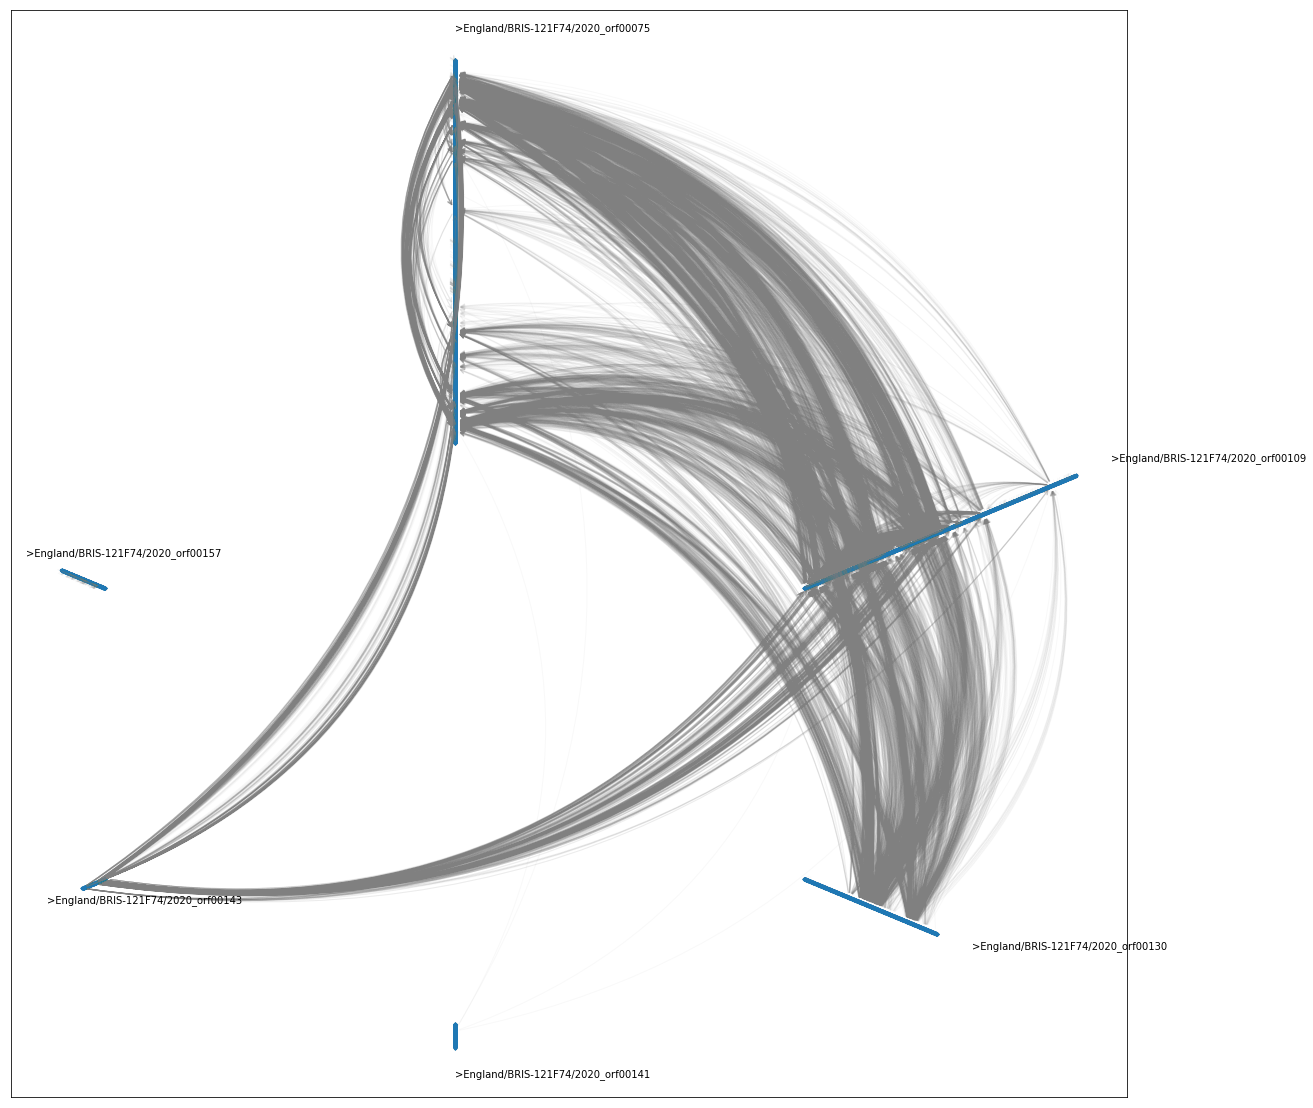

In [47]:
test = False
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(G, positions, node_size=5 )
ax = plt.gca()
for i,tup in enumerate(postuples):
    if i %10 == 0 :
        
        x1,y1 = tup[0]
        x2,y2 = tup[1]

        ax.annotate("",
                    xy=(x1, y1), xycoords='data',
                    xytext=(x2, y2), textcoords='data',
                    arrowprops=dict(arrowstyle="->", color="0.5", alpha = .05 ,
                                    shrinkA=5, shrinkB=5,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=0.3",
                                    ),
                    )
    #add protnames
for i, prot in enumerate(genomesDF.index):
    
    theta = i *theta_delta
    r = r0 + (genomesDF.loc[prot]['stop']-genomesDF.loc[prot]['start']) *r_delta + 100
    ax.annotate( prot , (r*math.sin(theta) , r*math.cos(theta)) )
print('plotting')
plt.show()
#visualize the interaction map of the proteome

In [13]:
import subprocess
import shlex

def runHHblits( aln , name, path , outdir, db , iterations , ncores , runName='' , SS= False  , ohhm = False , verbose = True , Z = 2000 , B = 2000 , xargs = ' -cons '):
    if verbose == True:
        print( [aln , name, path , outdir, db , iterations , ncores , runName] )
    outhhr= outdir+name+runName+".hhr"
    args = path + ' -cpu '+ str(ncores) +' -d ' + db + ' -i ' + aln  +' -o '+ outhhr + ' -n ' + str(iterations) + ' -B '+ str(B) + ' -Z ' + str(Z) +' '+ xargs 
    if SS == True:
         args += ' -ssm 2 -ssw .5 '
    
    if ohhm == True:
        outa3m = outdir+name+runName+'.a3m'
        args += ' -Oa3m ' + outa3m
    else: 
        outa3m = None
    if verbose == True:
        print(args)
    args = shlex.split( args)
    p = subprocess.run( args )
    return p , [outhhr,outa3m]

In [21]:
import glob
prots = glob.glob('./UKdata/proteome*singleseq.fasta')
print(prots)

['./UKdata/proteome_England_BRIS-121F74_2020_orf00109singleseq.fasta', './UKdata/proteome_England_BRIS-121F74_2020_orf00075singleseq.fasta', './UKdata/proteome_England_BRIS-121F74_2020_orf00141singleseq.fasta', './UKdata/proteome_England_BRIS-121F74_2020_orf00143singleseq.fasta', './UKdata/proteome_England_BRIS-121F74_2020_orf00130singleseq.fasta', './UKdata/proteome_England_BRIS-121F74_2020_orf00157singleseq.fasta']


In [22]:
#run hhblits
results = {}
for prot in prots:    
    p, outfiles = runHHblits( prot , prot+'.hhr' , 'hhblits', outdir = './' , db ='/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70' , ohhm = True,  iterations = 1 , ncores = 8 , )
    results[prot]=outfiles

['./UKdata/proteome_England_BRIS-121F74_2020_orf00109singleseq.fasta', './UKdata/proteome_England_BRIS-121F74_2020_orf00109singleseq.fasta.hhr', 'hhblits', './', '/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70', 1, 8, '']
hhblits -cpu 8 -d /home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70 -i ./UKdata/proteome_England_BRIS-121F74_2020_orf00109singleseq.fasta -o ././UKdata/proteome_England_BRIS-121F74_2020_orf00109singleseq.fasta.hhr.hhr -n 1 -B 2000 -Z 2000  -cons  -Oa3m ././UKdata/proteome_England_BRIS-121F74_2020_orf00109singleseq.fasta.hhr.a3m
['./UKdata/proteome_England_BRIS-121F74_2020_orf00075singleseq.fasta', './UKdata/proteome_England_BRIS-121F74_2020_orf00075singleseq.fasta.hhr', 'hhblits', './', '/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70', 1, 8, '']
hhblits -cpu 8 -d /home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70 -i ./UKdata/proteome_England_BRIS-121F74_2020_orf00075singleseq.fasta -o ././UKdata/proteome_England_BRIS-121F74_2020_orf00075singleseq.fasta.hhr.hhr -n 1 -B 2000 -Z 20

In [43]:
#parse results
from csb.bio.io.hhpred import HHOutputParser
predDfs  = {}
topk = 3
models = []
predictions = glob.glob( './UKdata/*single*.hhr')
for pred in predictions:
    results = HHOutputParser(alignments=False).parse_file(pred)
    newhits = {}
    hitlist=[]
    for hit in results:
        hitlist.append(hit.id)
        newhits.update( {  hit.id : { 'prob':hit.probability, 'len' : hit.length , 'score': hit.score   , 'start':hit.start , 'stop':hit.end }}  )

    hhdf = pd.DataFrame.from_dict(newhits, orient = 'index')
    hhdf['model'] = hhdf.index.map(lambda x : x.split('_')[0])
    hhdf['chain'] = hhdf.index.map(lambda x : x.split('_')[1])
    print(hhdf.head())
    predDfs[pred] = hhdf
    models+=list(hhdf.model)[0:topk]
print(models)
    

        prob   len   score  start  stop model chain
6ACC_B   1.0  1200  1957.9      1  1200  6ACC     B
6CS2_B   1.0  1161  1857.3     22  1182  6CS2     B
5I08_B   1.0  1265  1684.7     29  1293  5I08     B
5X5F_C   1.0  1275  1670.7     12  1286  5X5F     C
3JCL_C   1.0  1213  1646.5     30  1242  3JCL     C
        prob  len  score  start  stop model chain
4UD1_B   1.0  162  297.3      3   164  4UD1     B
1SSK_A   1.0  141  281.6     18   158  1SSK     A
2OFZ_A   1.0  128  269.2     11   138  2OFZ     A
2GEC_B   1.0  138  260.2      2   139  2GEC     B
4KXJ_A   1.0  130  259.0      7   136  4KXJ     A
         prob  len  score  start  stop model chain
1PON_A  0.551   18   16.7     17    34  1PON     A
5I0I_G  0.441   19   16.6     13    31  5I0I     G
3AKB_A  0.220   20   20.7     16    35  3AKB     A
2SCP_A  0.283   19   22.0    106   124  2SCP     A
5VP3_A  0.277   19   22.7    138   156  5VP3     A
          prob  len  score  start  stop model chain
2C6A_A   0.300   17   24.1    

In [44]:
from skbio import TabularMSA, Protein

from Bio.Alphabet.IUPAC import protein as alpha


alpha = list(alpha.letters)+['-'] 
print(alpha)


['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']


In [45]:
#now we have some long high quality hits to some chains
#get templates
import wget
import glob

dl_url = 'http://files.rcsb.org/download/'
structs = {}
already = glob.glob( './templates/*.pdb' )
for m in models:
    print(m)
    structfile = './templates/'+m.upper()+'.pdb'
    structs[m]= structfile
    if structfile not in already:
        wget.download(url = dl_url + m +'.pdb' , out =structfile)

6ACC
6CS2
5I08
4UD1
1SSK
2OFZ
1PON
5I0I
3AKB
2C6A
2CR8
4XXB
6NUR
5NFY
5C8S
5C5O
2Z3E
5N19


In [46]:
from Bio.PDB import *
#find ca string for each strucutre
#make sure you grab the right chain
from Bio import Alphabet
parser = PDBParser()
from Bio.SeqUtils import seq1
letter3 = Alphabet.ThreeLetterProtein.letters
converter = { l.upper(): seq1(l) for l in letter3} 
print(converter)

{'ALA': 'A', 'ASX': 'B', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T', 'SEC': 'U', 'VAL': 'V', 'TRP': 'W', 'XAA': 'X', 'TYR': 'Y', 'GLX': 'Z'}


In [79]:
models = {}
ali_input = {}
builder = Polypeptide.PPBuilder()
#slice structures in hhr

io=PDBIO()
sliceprots = False


class resselect(Select):
    def __init__(self, reslist):
        self.reslist=reslist
    
    def accept_residue(self ,residue ):
        if residue in self.reslist:
            return 1
        else:
            return 0      
for df in predDfs:
    print(predDfs[df])
    count = 0
    for i,row in predDfs[df].iterrows():
        if count < topk:
            count+=1
            code = row.model
            if code in structs:
                print(code)

                structure = parser.get_structure(code,structs[code])
                io.set_structure(structure)

                for chain in structure.get_chains():
                    if chain.id == row.chain:
                        #trim the structures to hhblits detected regions
                        if sliceprots == True:
                            #Dice.extract(structure=structure , chain_id=chain.id , start=row.start-1, end=row.stop , filename='./modellercif/'+row.model+'.pdb' )
                            #sub_structure = parser.get_structure(code , './modellercif/'+row.model+'.pdb' )
                            #subchains = [ c for c in structure.get_chains()]
                            peptides  = [p for p in  builder.build_peptides(chain)]
                            peptidelen  = [len(p) for p in  builder.build_peptides(chain)]
                            print(peptidelen)

                        else:
                            #Dice.extract(structure=structure , chain_id=chain.id , start=0, end=len(chain), filename='./modellercif/'+row.model+'.pdb' )

                            #sub_structure = parser.get_structure(code , './modellercif/'+row.model+'.pdb' )
                            #sub_structure = structure
                            peptides  = [p for p in  builder.build_peptides(chain)]
                            peptidelen  = [len(p) for p in  builder.build_peptides(chain)]
                            print(peptidelen)
                            #pp = peptides[0]

                        for i,pp in enumerate( peptides):
                            #break all subchains into files
                            if peptidelen[i] > 75:
                                io.save('./modellercif/'+row.model+'_'+str(i) +'.pdb', resselect(pp))
                                seq = str(pp.get_sequence())
                                print(seq)
                                models[row.model+'_'+str(i)]={'mdl': './modellercif/'+row.model+'_'+str(i) +'.pdb' , 'chain':chain.id }
                            #ali_input[row.model] = { 'chain': subchains[0].id , 'seq': seq , 'start':'' , 'stop':''  } 
                        #mdl = model(env, file='./modellercif/'+row.model+'.pdb', model_segment=('FIRST:'+chain.id, 'LAST:'+chain.id))
                        #chains = mdl.make_chains(file='./modellercif/'+row.model+'.pdb')

                        #for i,pp in enumerate(peptides):
                        #    if i > 0:
                        #        seq+='-'
                        #    seq += str(pp.get_sequence())
                        #ali_input[row.model] = { 'chain': subchains[0].id , 'seq': seq , 'start':'' , 'stop':''  }     
                        # grab all sequences from the query input

print('DONE')

         prob   len   score  start  stop model chain
6ACC_B  1.000  1200  1957.9      1  1200  6ACC     B
6CS2_B  1.000  1161  1857.3     22  1182  6CS2     B
5I08_B  1.000  1265  1684.7     29  1293  5I08     B
5X5F_C  1.000  1275  1670.7     12  1286  5X5F     C
3JCL_C  1.000  1213  1646.5     30  1242  3JCL     C
...       ...   ...     ...    ...   ...   ...   ...
3OGI_A  0.204    67    26.8     11    77  3OGI     A
5HJ3_H  0.201    35    31.9     60    94  5HJ3     H
6RX1_A  0.200    53    31.0     12    64  6RX1     A
5J65_A  0.200    12    35.1    180   191  5J65     A
5KUC_A  0.200    12    35.1    180   191  5KUC     A

[119 rows x 7 columns]
6ACC
[222, 417, 138, 288]
RCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFS
IWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKF

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 28874.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 29275.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 29665.
  PDBConstructionWarning)


[223, 124, 132, 155, 139, 6, 297]
RCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSP
IWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCY
ATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFE
TVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTV
QKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVT
LICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQ

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10833.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10838.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 10867.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 10896.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 10910.
 

[133]
PKPRAAPNNTVSWYTGLTQHGKVPLTFPPGQGVPLNANSTPAQNAGYWRRQDRKINTGNGIKQLAPRWYFYYTGTGPEAALPFRAVKDGIVWVHEDGATDAPSTFGTRNPNNDSAIVTQFAPGTKLPKNFHIE
1SSK
[158]
MGSSHHHHHHSSGLVPRGSAMGLPNNTASWFTALTQHGKEELRFPRGQGVPINTNSGPDDQIGYYRRATRRVRGGDGKMKELSPRWYFYYLGTGPEASLPYGANKEGIVWVATEGALNTPKDHIGTRNPNNNAATVLQLPQGTTLPKGFYAEGSRGGS
2OFZ
[6, 126]
NTASWFTALTQHGKEELRFPRGQGVPINTNSGPDDQIGYYRRATRRVRGGDGKMKELSPRWYFYYLGTGPEASLPYGANKEGIVWVATEGALNTPKDHIGTRNPNNNAATVLQLPQGTTLPKGFYA
         prob  len  score  start  stop model chain
1PON_A  0.551   18   16.7     17    34  1PON     A
5I0I_G  0.441   19   16.6     13    31  5I0I     G
3AKB_A  0.220   20   20.7     16    35  3AKB     A
2SCP_A  0.283   19   22.0    106   124  2SCP     A
5VP3_A  0.277   19   22.7    138   156  5VP3     A
5XPD_A  0.271   19   27.1     79    97  5XPD     A
2CCM_B  0.208   18   21.1    121   138  2CCM     B
2KI0_A  0.213   11   22.4     13    23  2KI0     A
1UHI_A  0.209   18   21.2    121   138  1UHI     A
1UHK_B  0.209   18   21.2    121   138 

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31634.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 31738.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 31822.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 31827.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 31832.
 

[43]
3AKB
[166]
EYERRIAARFTTFDQDGNGHIDRSDFSGAAKAMLAEFGVAARSDRGQALYGGAEALWQGLAGIADRDGDQRITREEFVTGAVKRLRDKPDRFAEMARPFLHAALGVADTDGDGAVTVADTARALTAFGVPEDLARQAAAALDTDGDGKVGETEIVPAFARYFTVPA
          prob  len  score  start  stop model chain
2C6A_A   0.300   17   24.1     11    27  2C6A     A
2CR8_A   0.282   23   24.8     10    32  2CR8     A
4XXB_B   0.278   24   28.5     12    35  4XXB     B
6U42_6J  0.255   22   27.8      2    23  6U42    6J
2YQL_A   0.152   11   16.7     46    56  2YQL     A
2KN0_A   0.135   28   23.8     28    55  2KN0     A
6NBH_R   0.127   25   26.1    431   455  6NBH     R
6NBF_R   0.127   25   26.1    431   455  6NBF     R
2KFT_A   0.115   12   15.7     42    53  2KFT     A
2L5U_A   0.115   13   16.8     48    60  2L5U     A
2C6A
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
[46]
2CR8
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
[53]
4XXB
[42]
         prob  len   scor

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2114.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2124.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2125.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 2182.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 9512.
  PDBC

[779, 14]
QRLTKYTMADLVYALRHFDEGNCDTLKEILVTYNCCDDDYFNKKDWYDFVENPDILRVYANLGERVRQSLLKTVQFCDAMRDAGIVGVLTLDNQDLNGNWYDFGDFVQVAPGCGVPIVDSYYSLLMPILTLTRALAAESHMDADLAKPLIKWDLLKYDFTEERLCLFDRYFKYWDQTYHPNCINCLDDRCILHCANFNVLFSTVFPPTSFGPLVRKIFVDGVPFVVSTGYHFRELGVVHNQDVNLHSSRLSFKELLVYAADPAMHAASGNLLLDKRTTCFSVAALTNNVAFQTVKPGNFNKDFYDFAVSKGFFKEGSSVELKHFFFAQDGNAAISDYDYYRYNLPTMCDIRQLLFVVEVVDKYFDCYDGGCINANQVIVNNLDKSAGFPFNKWGKARLYYDSMSYEDQDALFAYTKRNVIPTITQMNLKYAISAKNRARTVAGVSICSTMTNRQFHQKLLKSIAATRGATVVIGTSKFYGGWHNMLKTVYSDVETPHLMGWDYPKCDRAMPNMLRIMASLVLARKHNTCCNLSHRFYRLANECAQVLSEMVMCGGSLYVKPGGTSSGDATTAYANSVFNICQAVTANVNALLSTDGNKIADKYVRNLQHRLYECLYRNRDVDHEFVDEFYAYLRKHFSMMILSDDAVVCYNSNYAAQGLVASIKNFKAVLYYQNNVFMSEAKCWTETDLTKGPHEFCSQHTMLVKQGDDYVYLPYPDPSRILGAGCFVDDIVKTDGTLMIERFVSLAIDAYPLTKHPNQEYADVFHLYLQYIRKLHDEL
5NFY


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 21856.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 21873.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 21876.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 21886.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain M is discontinuous at line 21889.
 

[453, 61]
AENVTGLFKDCSKIITGLHPTQAPTHLSVDIKFKTEGLCVDIPGIPKDMTYRRLISMMGFKMNYQVNGYPNMFITREEAIRHVRAWIGFDVEGCHATRDAVGTNLPLQLGFSTGVNLVAVPTGYVDTENNTEFTRVNAKPPPGDQFKHLIPLMYKGLPWNVVRIKIVQMLSDTLKGLSDRVVFVLWAHGFELTSMKYFVKIGPERTCCLCDKRATCFSTSSDTYACWNHSVGFDYVYNPFMIDVQQWGFTGNLQSNHDQHCQVHGNAHVASCDAIMTRCLAVHECFVKRVDWSVEYPIIGDELRVNSACRKVQHMVVKSALLADKFPVLHDIGNPKAIKCVPQAEVEWKFYDAQPCSDKAYKIEELFYSYAIHHDKFTDGVCLFWNCNVDRYPANAIVCRFDTRVLSNLNLPGCDGGSLYVNKHAFHTPAFDKSAFTNLKQLPFFYYSDSPCE
5C8S


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11124.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11126.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11206.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11208.
  PDBConstructionWarning)


[453, 61]
AENVTGLFKDCSKIITGLHPTQAPTHLSVDIKFKTEGLCVDIPGIPKDMTYRRLISMMGFKMNYQVNGYPNMFITREEAIRHVRAWIGFDVEGCHATRDAVGTNLPLQLGFSTGVNLVAVPTGYVDTENNTEFTRVNAKPPPGDQFKHLIPLMYKGLPWNVVRIKIVQMLSDTLKGLSDRVVFVLWAHGFELTSMKYFVKIGPERTCCLCDKRATCFSTSSDTYACWNHSVGFDYVYNPFMIDVQQWGFTGNLQSNHDQHCQVHGNAHVASCDAIMTRCLAVHECFVKRVDWSVEYPIIGDELRVNSACRKVQHMVVKSALLADKFPVLHDIGNPKAIKCVPQAEVEWKFYDAQPCSDKAYKIEELFYSYATHHDKFTDGVCLFWNCNVDRYPANAIVCRFDTRVLSNLNLPGCDGGSLYVNKHAFHTPAFDKSAFTNLKQLPFFYYSDSPCE
         prob  len  score  start  stop model chain
5C5O_B  1.000  306  565.2      1   306  5C5O     B
2Z3E_A  1.000  306  564.5      1   306  2Z3E     A
5N19_A  1.000  306  564.5      1   306  5N19     A
2YNA_A  1.000  306  553.4      1   306  2YNA     A
4YOJ_B  1.000  306  553.4      1   306  4YOJ     B
...       ...  ...    ...    ...   ...   ...   ...
1HK8_A  0.247   55   41.8    530   584  1HK8     A
1H77_.  0.247   55   41.8    530   584  1H77     .
1H7A_A  0.247   55   41.8    530   584  1H7A     A
5JB3_Y  0.237   28   28.5 

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5128.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5160.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5192.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5402.
  PDBConstructionWarning)


[300]
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDIQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQC
2Z3E
[306]


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 2927.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 3144.
  PDBConstructionWarning)


SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDRQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQCSGVTFQ
5N19
[306]
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDRQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQCSGVTFQ


In [82]:
from modeller import *
import modeller.salign
log.none()
env = environ()
env.io.atom_files_directory = ['./modellercif/']
knowns = {}
structalns = {}

#aln = alignment(env, file='align2d_in.ali', align_codes='all' )
print(models)
for df in predDfs:
    print(predDfs[df])
    count = 0
    knowns[df]=[]
    for i,row in predDfs[df].iterrows():
        if count < topk:
            count +=1
            model_list = list(predDfs[df].model)[0:topk]
            aln = alignment(env)
            
            for m in models:
                if m.split('_')[0] in model_list:
                    print(m)
                    mdl = model(env, file=m, model_segment=('FIRST:'+models[m]['chain'], 'LAST:'+models[m]['chain']))
                    aln.append_model(mdl, atom_files=m, align_codes= m)
                    knowns[df].append(m)
            print(aln)
            try:
                for (weights, write_fit, whole) in (((1., 0., 0., 0., 1., 0.), False, True),
                                            ((1., 0.5, 1., 1., 1., 0.), False, True),
                                            ((1., 1., 1., 1., 1., 0.), True, False)):
                    aln.salign(rms_cutoff=3.5, normalize_pp_scores=False,
                       rr_file='$(LIB)/as1.sim.mat', overhang=30,
                       gap_penalties_1d=(-450, -50),
                       gap_penalties_3d=(0, 3), gap_gap_score=0, gap_residue_score=0,
                       dendrogram_file='1is3A.tree',
                       alignment_type='tree',
                       feature_weights=weights, # For a multiple sequence alignment only
                       improve_alignment=True, fit=True, write_fit=write_fit,
                       write_whole_pdb=whole, output='ALIGNMENT QUALITY')
                    #aln.write(file='1is3A-it.pap', alignment_format='PAP')
                    structalns[df] = df+'.ali'
                    aln.write(file= structalns[df], alignment_format='PIR')
            except:
                print('alnerr')
            print('DONE')
print(knowns)

{'6ACC_0': {'mdl': './modellercif/6ACC_0.pdb', 'chain': 'B'}, '6ACC_1': {'mdl': './modellercif/6ACC_1.pdb', 'chain': 'B'}, '6ACC_2': {'mdl': './modellercif/6ACC_2.pdb', 'chain': 'B'}, '6ACC_3': {'mdl': './modellercif/6ACC_3.pdb', 'chain': 'B'}, '6CS2_0': {'mdl': './modellercif/6CS2_0.pdb', 'chain': 'B'}, '6CS2_1': {'mdl': './modellercif/6CS2_1.pdb', 'chain': 'B'}, '6CS2_2': {'mdl': './modellercif/6CS2_2.pdb', 'chain': 'B'}, '6CS2_3': {'mdl': './modellercif/6CS2_3.pdb', 'chain': 'B'}, '6CS2_4': {'mdl': './modellercif/6CS2_4.pdb', 'chain': 'B'}, '6CS2_6': {'mdl': './modellercif/6CS2_6.pdb', 'chain': 'B'}, '5I08_0': {'mdl': './modellercif/5I08_0.pdb', 'chain': 'B'}, '5I08_1': {'mdl': './modellercif/5I08_1.pdb', 'chain': 'B'}, '5I08_2': {'mdl': './modellercif/5I08_2.pdb', 'chain': 'B'}, '5I08_6': {'mdl': './modellercif/5I08_6.pdb', 'chain': 'B'}, '5I08_7': {'mdl': './modellercif/5I08_7.pdb', 'chain': 'B'}, '4UD1_0': {'mdl': './modellercif/4UD1_0.pdb', 'chain': 'B'}, '1SSK_0': {'mdl': './mo

In [85]:
blockct = 0
print('making sequence pir')

from Bio import SeqIO
print(predDfs.keys())
finalaln = {}
alidfs = {}
#write out each seq as a gapless pir
for df in predDfs:
    fasta = df.replace('.hhr', '')
    print(fasta)
    ali_input ={}
    for seq in SeqIO.parse(fasta , 'fasta'):
        ali_input[seq.id] = { 'chain': '', 'seq': str(seq.seq) , 'start':1 , 'stop':len(seq.seq)  } 
    alidf = pd.DataFrame.from_dict( ali_input , orient = 'index')
    print(alidf.head())
    
    
    alidfs[df]=alidf
    
    
    with open( fasta+'.ali' , 'w') as alnout:
        for idx,row in alidf.iterrows():
            print(row)
            if len(row.chain ) > 0:
                pass
            #    line2 = 'structureX:'+idx+':'+str(row.start)+' :'+row.chain + ':' + str( row.stop  )  + ':::::'+'\n'
            else:
                blockct+=1
                print(idx)
                line1 = '>P1;'+idx.replace('/','_') +'\n'
                line2 = 'sequence:'+idx+':1 : :'+str( len(row.seq) )  + ':::::' +'\n' 
                line3 = row.seq +'*\n'
                #print(  line1 + line2 + line3)
                alnout.write( line1 + line2 + line3)

    print('aln struct block to seq block ')   
    #structure sensitive aln

    aln = alignment(env, file=fasta+'.ali' , align_codes='all' )
    try:
        aln.append(file=structalns[df], align_codes='all')
        aln.salign(
                       align_block= blockct,
                       gap_penalties_1d=(-10, 0),
                       gap_penalties_2d=(3.5, 3.5, 3.5, 0.2, 4.0, 6.5, 2.0, 0.0, 0.0),
                    fit = True
                       # d.p. score matrix
                       #output_weights_file='salign.mtx'
                       )
        """aln.write(file='align2d.pap', alignment_format='PAP',
                  alignment_features='INDICES HELIX BETA STRAIGHTNESS ' + \
                                     'ACCESSIBILITY CONSERVATION')
        """
        
        #output aln
        finalaln[df] = df+'final.ali'
        aln.write(file=finalaln[df], alignment_format='PIR')
        print('DONE')
    except:
        print('alnerr')

making sequence pir
dict_keys(['./UKdata/proteome_England_BRIS-121F74_2020_orf00130singleseq.fasta.hhr.hhr', './UKdata/proteome_England_BRIS-121F74_2020_orf00157singleseq.fasta.hhr.hhr', './UKdata/proteome_England_BRIS-121F74_2020_orf00143singleseq.fasta.hhr.hhr', './UKdata/proteome_England_BRIS-121F74_2020_orf00141singleseq.fasta.hhr.hhr', './UKdata/proteome_England_BRIS-121F74_2020_orf00109singleseq.fasta.hhr.hhr', './UKdata/proteome_England_BRIS-121F74_2020_orf00075singleseq.fasta.hhr.hhr'])
./UKdata/proteome_England_BRIS-121F74_2020_orf00130singleseq.fasta
                                   chain  \
>England/BRIS-121F74/2020_orf00130         

                                                                                  seq  \
>England/BRIS-121F74/2020_orf00130  MFVFLVLLPLVSSQCVNFTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   

                                    start  stop  
>England/BRIS-121F74/2020_orf00130      1  1273  
chain                                                     
seq   

In [91]:
#run modeller
print(models)

# Comparative modeling by the automodel class
from modeller import *              # Load standard Modeller classes
from modeller.automodel import *    # Load the automodel class
print(knowns)
env = environ() 
env.io.atom_files_directory = ['./modellercif/', './']

for df in finalaln:
    alidf = alidfs[df]
    print(alidf)
    
    print(finalaln[df])
    for seq in alidf.index:
        a = automodel(env,
                      alnfile  =  finalaln[df] ,     # alignment filename
                      knowns   =  knowns[df] ,              # codes of the templates
                      sequence =  seq.replace('/','_')   )
        # code of the target
        
        a.starting_model= 1                 # index of the first model
        a.ending_model  = 1                 # index of the last model
        a.repeat_optimization = 1
        a.make()                            # do the actual comparative modeling
print('DONE')

{'6ACC_0': {'mdl': './modellercif/6ACC_0.pdb', 'chain': 'B'}, '6ACC_1': {'mdl': './modellercif/6ACC_1.pdb', 'chain': 'B'}, '6ACC_2': {'mdl': './modellercif/6ACC_2.pdb', 'chain': 'B'}, '6ACC_3': {'mdl': './modellercif/6ACC_3.pdb', 'chain': 'B'}, '6CS2_0': {'mdl': './modellercif/6CS2_0.pdb', 'chain': 'B'}, '6CS2_1': {'mdl': './modellercif/6CS2_1.pdb', 'chain': 'B'}, '6CS2_2': {'mdl': './modellercif/6CS2_2.pdb', 'chain': 'B'}, '6CS2_3': {'mdl': './modellercif/6CS2_3.pdb', 'chain': 'B'}, '6CS2_4': {'mdl': './modellercif/6CS2_4.pdb', 'chain': 'B'}, '6CS2_6': {'mdl': './modellercif/6CS2_6.pdb', 'chain': 'B'}, '5I08_0': {'mdl': './modellercif/5I08_0.pdb', 'chain': 'B'}, '5I08_1': {'mdl': './modellercif/5I08_1.pdb', 'chain': 'B'}, '5I08_2': {'mdl': './modellercif/5I08_2.pdb', 'chain': 'B'}, '5I08_6': {'mdl': './modellercif/5I08_6.pdb', 'chain': 'B'}, '5I08_7': {'mdl': './modellercif/5I08_7.pdb', 'chain': 'B'}, '4UD1_0': {'mdl': './modellercif/4UD1_0.pdb', 'chain': 'B'}, '1SSK_0': {'mdl': './mo

In [92]:
#run modeller
print(models)

# Comparative modeling by the automodel class
from modeller import *              # Load standard Modeller classes
from modeller.automodel import *    # Load the automodel class
print(knowns)
env = environ() 
env.io.atom_files_directory = ['./modellercif/']

for df in finalaln:
    alidf = alidfs[df]
    print(alidf)
    
    first   =  knowns[df][0].split('_')[0]
    
    firststruct = [ s for s in knowns[df] if first in s]
    
    print(finalaln[df])
    for seq in alidf.index: 
        a = automodel(env,
                      alnfile  = finalaln[df],     # alignment filename
                      knowns   =  firststruct ,              # codes of the templates
                      sequence =   seq.replace('/','_')  )              # code of the target
        a.starting_model= 1                 # index of the first model
        a.ending_model  = 1                 # index of the last model
        a.repeat_optimization = 2
        a.make()                            # do the actual comparative modeling

print('DONE')

{'6ACC_0': {'mdl': './modellercif/6ACC_0.pdb', 'chain': 'B'}, '6ACC_1': {'mdl': './modellercif/6ACC_1.pdb', 'chain': 'B'}, '6ACC_2': {'mdl': './modellercif/6ACC_2.pdb', 'chain': 'B'}, '6ACC_3': {'mdl': './modellercif/6ACC_3.pdb', 'chain': 'B'}, '6CS2_0': {'mdl': './modellercif/6CS2_0.pdb', 'chain': 'B'}, '6CS2_1': {'mdl': './modellercif/6CS2_1.pdb', 'chain': 'B'}, '6CS2_2': {'mdl': './modellercif/6CS2_2.pdb', 'chain': 'B'}, '6CS2_3': {'mdl': './modellercif/6CS2_3.pdb', 'chain': 'B'}, '6CS2_4': {'mdl': './modellercif/6CS2_4.pdb', 'chain': 'B'}, '6CS2_6': {'mdl': './modellercif/6CS2_6.pdb', 'chain': 'B'}, '5I08_0': {'mdl': './modellercif/5I08_0.pdb', 'chain': 'B'}, '5I08_1': {'mdl': './modellercif/5I08_1.pdb', 'chain': 'B'}, '5I08_2': {'mdl': './modellercif/5I08_2.pdb', 'chain': 'B'}, '5I08_6': {'mdl': './modellercif/5I08_6.pdb', 'chain': 'B'}, '5I08_7': {'mdl': './modellercif/5I08_7.pdb', 'chain': 'B'}, '4UD1_0': {'mdl': './modellercif/4UD1_0.pdb', 'chain': 'B'}, '1SSK_0': {'mdl': './mo

KeyboardInterrupt: 